# Multipole misalignment in CMBLensed

In [1]:
import os
import contextlib
import tempfile
import healpy as hp
import matplotlib.pyplot as plt
import pysm3
import pysm3.units as u
from pysm3.models.cmb import CMBMap
from pysm3.models.cmb import CMBLensed as CMBLensedOriginal

CAMB output power spectra include the monopole and dipole ($\ell=0$ and $\ell=1$), but the `c1` power spectra do not:

Instead of adding a dependency, please trust that CAMB produces spectra of this form.

```
CAMB output power spectra:
      #  L TT            EE            BB            TE            PP            PT            PE
         0 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
         1 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
         2 1.0825953e+03 1.4746664e-01 1.4796820e-07 6.6772338e+00 5.2118790e-08 2.7735919e-03 -2.5091173e-05
         3 1.0465663e+03 3.9779316e-01 2.9968791e-07 1.0461787e+01 6.2924300e-08 2.8439773e-03 -3.7494399e-05
         4 9.9860773e+02 7.4959835e-01 5.0778217e-07 1.3168715e+01 7.2089927e-08 2.8437573e-03 -4.7767740e-05
```

In [2]:
# ps_camb = "demo_powerspectra/camb_ps.dat"  # Only used to demonstrate that CAMB output includes L=0,1
ps_c1_fn_remote = "pysm_2/camb_lenspotentialCls.dat"

ps_c1_fn_local = pysm3.utils.RemoteData().get(ps_c1_fn_remote)

print("Original c1 power spectra:")
with open(ps_c1_fn_local, "r") as f:
    for i in range(4):
        print(' '*5, f.readline().rstrip())

Original c1 power spectra:
      #    L    TT             EE             BB             TE             PP             TP             EP
           2    0.10678E+04    0.34282E-01    0.00000E+00    0.27104E+01    0.49277E-07    0.32326E-02   -0.12847E-04
           3    0.10029E+04    0.46186E-01    0.00000E+00    0.31328E+01    0.60013E-07    0.32173E-02   -0.14138E-04
           4    0.94274E+03    0.42475E-01    0.00000E+00    0.30100E+01    0.69182E-07    0.31297E-02   -0.12452E-04


I create a context that will provide a file with a version of the `c1` spectra containing L=0 and L=1:

In [3]:

@contextlib.contextmanager
def temp_cl_l01():
    with open(ps_c1_fn_local, "r") as f:
        lines = f.readlines()

    l0 = "     0    0.00000E+00    0.00000E+00    0.00000E+00    0.00000E+00    0.00000E+00    0.00000E+00    0.00000E+00\n"
    l1 = "     1    0.00000E+00    0.00000E+00    0.00000E+00    0.00000E+00    0.00000E+00    0.00000E+00    0.00000E+00\n"
    lines.insert(1, l0)
    lines.insert(2, l1)

    ps_c1_l01_str = "".join(lines)
    """Context manager to create a temporary text file with the given content."""
    with tempfile.NamedTemporaryFile("w+", delete=False) as temp_file:
        temp_file.write(ps_c1_l01_str)
        temp_file.flush()  # Ensure content is written
        yield temp_file.name  # Provide the filename for use

    # Cleanup happens after exiting `with` block
    try:
        os.remove(temp_file.name)
    except OSError:
        print(f"Warning: Could not delete {temp_file.name}")

with temp_cl_l01() as ps_c1_l01_fn_local:
    print("Original c1 power spectra:")
    with open(ps_c1_l01_fn_local, "r") as f:
        for i in range(6):
            print(' '*5, f.readline().rstrip())

Original c1 power spectra:
      #    L    TT             EE             BB             TE             PP             TP             EP
           0    0.00000E+00    0.00000E+00    0.00000E+00    0.00000E+00    0.00000E+00    0.00000E+00    0.00000E+00
           1    0.00000E+00    0.00000E+00    0.00000E+00    0.00000E+00    0.00000E+00    0.00000E+00    0.00000E+00
           2    0.10678E+04    0.34282E-01    0.00000E+00    0.27104E+01    0.49277E-07    0.32326E-02   -0.12847E-04
           3    0.10029E+04    0.46186E-01    0.00000E+00    0.31328E+01    0.60013E-07    0.32173E-02   -0.14138E-04
           4    0.94274E+03    0.42475E-01    0.00000E+00    0.30100E+01    0.69182E-07    0.31297E-02   -0.12452E-04


I'll need a helper function to display some maps:

In [4]:
def compare_maps(params, 
                    dl1 = ps_c1_fn_remote, dl2 = None, 
                    cmbl1 = CMBLensedOriginal, cmbl2 = CMBLensedOriginal,
                    label1="Original c1; Original CMBLensed", label2="c1 with L=0,1; Original CMBLensed"):
    if dl2 is None:
        raise ValueError("dl2 must be provided")
    m1 = cmbl1(cmb_spectra = dl1, **params).map
    m2 = cmbl2(cmb_spectra = dl2, **params).map
    fig, axs = plt.subplots(3, 3, figsize=(12, 8))
    plt.sca(axs[0,0])
    hp.mollview(m2[0], title=f"{label1} T", hold=True)
    plt.sca(axs[0,1])
    hp.mollview(m2[1], title=f"{label1} Q", hold=True)
    plt.sca(axs[0,2])
    hp.mollview(m2[2], title=f"{label1} U", hold=True)
    plt.sca(axs[1,0])
    hp.mollview(m1[0], title=f"{label2} T", hold=True)
    plt.sca(axs[1,1])
    hp.mollview(m1[1], title=f"{label2} Q", hold=True)
    plt.sca(axs[1,2])
    hp.mollview(m1[2], title=f"{label2} U", hold=True)
    plt.sca(axs[2,0])
    hp.mollview(m1[0] - m2[0], title="Delta T", hold=True)
    plt.sca(axs[2,1])
    hp.mollview(m1[1] - m2[1], title="Delta Q", hold=True)
    plt.sca(axs[2,2])
    hp.mollview(m1[2] - m2[2], title="Delta U", hold=True)
    plt.show()

When I use `CMBLensed` with the original `c1` spectra, the output differs from when I use it with the modified `c1` spectra.

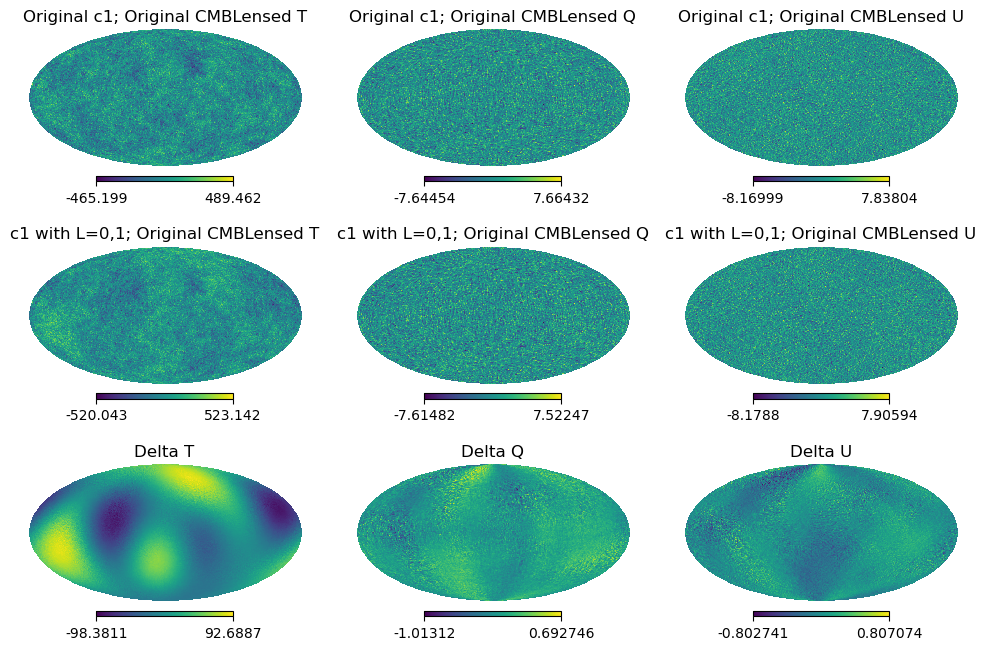

In [5]:
with temp_cl_l01() as ps_c1_with_l01_fn:
    params = dict(
        nside=128,
        max_nside=None,
        cmb_seed=0,
        apply_delens=False,
        delensing_ells=None,
        map_dist=None,
    )
    compare_maps(params, 
                    dl1 = ps_c1_fn_remote, dl2 = ps_c1_with_l01_fn, 
                    cmbl1 = CMBLensedOriginal, cmbl2 = CMBLensedOriginal,
                    label1="Original c1; Original CMBLensed", 
                    label2="c1 with L=0,1; Original CMBLensed")

# Resolution

Minimal changes to the `__init__` method of `CMBLensed` can account for this (lines 46-48):

In [ ]:
# Revised, minimal changes to the __init__ method are all that is needed

class CMBLensedRevised(CMBMap):
    # intherit from CMBMap so we get the `get_emission` method
    def __init__(
        self,
        nside,
        cmb_spectra,
        max_nside=None,
        cmb_seed=None,
        apply_delens=False,
        delensing_ells=None,
        map_dist=None,
    ):
        """Lensed CMB

        Takes an input unlensed CMB and lensing spectrum from CAMB and uses
        Taylens to apply lensing, it optionally simulates delensing by
        suppressing the lensing power at specific scales with the user
        provided `delensing_ells`.

        Parameters
        ----------

        cmb_spectra : path
            Input text file from CAMB, spectra unlensed
        cmb_seed : int
            Numpy random seed for synfast, set to None for a random seed
        apply_delens : bool
            If true, simulate delensing with taylens
        delensing_ells : path
            Space delimited file with ells in the first columns and suppression
            factor (1 for no suppression) in the second column
        """
        try:
            super().__init__(nside=nside, max_nside=max_nside, map_dist=map_dist)
        except ValueError:
            pass  # suppress exception about not providing any input map
        self.cmb_spectra = self.read_txt(cmb_spectra, unpack=True)
        self.cmb_seed = cmb_seed
        self.apply_delens = apply_delens
        self.delensing_ells = (
            None if delensing_ells is None else self.read_txt(delensing_ells)
        )

        # Remove monopole and dipole, if present in cmb_spectra
        if self.cmb_spectra[0][0] == 0:
            self.cmb_spectra = self.cmb_spectra[:, 2:]
        # Remove monopole and dipole, if present in delensing_ells
        if self.apply_delens and self.delensing_ells[0][0] == 0:
            self.delensing_ells = self.delensing_ells[:, 2:]

        self.map = u.Quantity(self.run_taylens(), unit=u.uK_CMB, copy=False)

    def run_taylens(self):
        pass

CMBLensedRevised.run_taylens = CMBLensedOriginal.run_taylens

The change handles the presence of monopole and dipole.

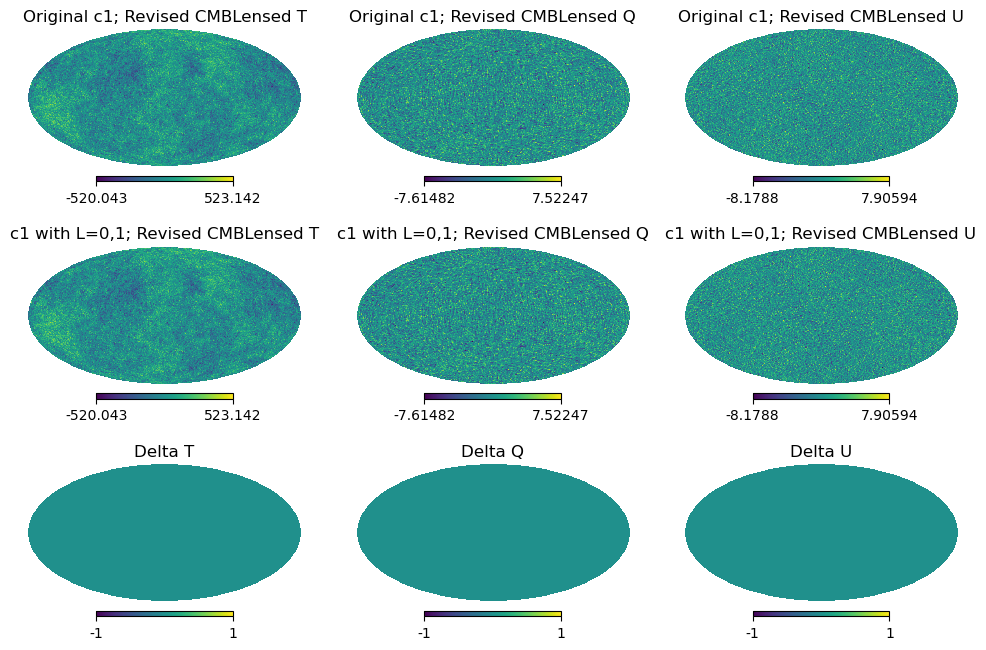

In [7]:
with temp_cl_l01() as ps_c1_with_l01_fn:
    params = dict(
        nside=128,
        max_nside=None,
        cmb_seed=0,
        apply_delens=False,
        delensing_ells=None,
        map_dist=None,
    )
    compare_maps(params, 
                    dl1 = ps_c1_fn_remote, dl2 = ps_c1_with_l01_fn, 
                    cmbl1 = CMBLensedRevised, cmbl2 = CMBLensedRevised,
                    label1="Original c1; Revised CMBLensed", 
                    label2="c1 with L=0,1; Revised CMBLensed")

# Using `RevisedCMBLensed` doesn't change anything it shouldn't

The results are the **same** for the original `c1` input:

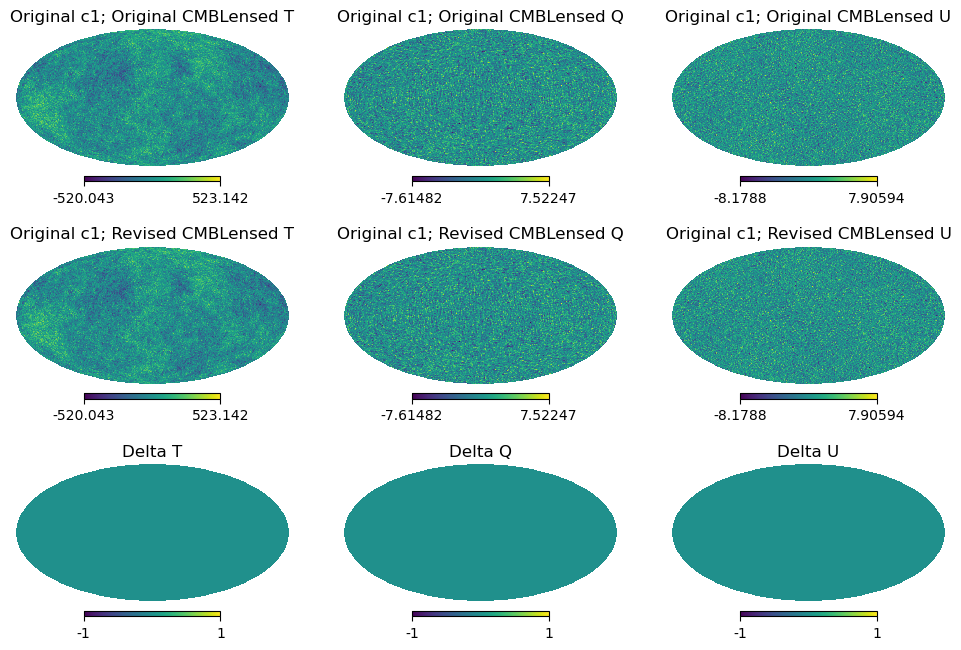

In [8]:
with temp_cl_l01() as ps_c1_with_l01_fn:
    params = dict(
        nside=128,
        max_nside=None,
        cmb_seed=0,
        apply_delens=False,
        delensing_ells=None,
        map_dist=None,
    )
    compare_maps(params, 
                    dl1 = ps_c1_fn_remote, dl2 = ps_c1_fn_remote, 
                    cmbl1 = CMBLensedOriginal, cmbl2 = CMBLensedRevised,
                    label1="Original c1; Original CMBLensed", 
                    label2="Original c1; Revised CMBLensed")